In [60]:
import itertools

import graph_tool.all as gt

import joblib
import numpy as np
import scipy as sp
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import *

%matplotlib inline
%autosave 15

Autosaving every 15 seconds


Приведём реализацию предложенного 2-оптимального алгоритма, используя примитивы из ```graph-tool```:

In [84]:
%%time
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))


def steiner_tree_2_opt(G, V0):
    """
    Given weighted undirected graph, finds an approximation to the Steiner tree
    that has at least two times larger cost than the real one.
    """
    n = G.num_vertices()
    sd_pm = gt.shortest_distance(G, weights=G.ep["w"], 
                                 directed=False, dense=True)
    sd = np.vstack([sd_pm[v] for v in G.vertices()])
    
    K_n = gt.complete_graph(n, directed=False)
    K_n.ep["w"] = K_n.new_edge_property("double")
    indices = np.triu_indices_from(sd, k=1) # https://vk.cc/8D03ZI
    K_n.ep["w"].a = np.asarray(sd[indices])
    
    V0_vfilt = K_n.new_vertex_property("bool")
    V0_vfilt.a[V0] = True
    K_V0 = gt.GraphView(K_n, vfilt=V0_vfilt.a)
    
    MST = gt.min_spanning_tree(K_V0, weights=K_n.ep["w"])
    mst_cost = np.sum(K_n.ep["w"].a[MST.a == 1])
    return mst_cost


def steiner_tree(G, V0):
    def process_mask(subset):
        if len(subset) == 0:
            return np.inf
        mask = np.full(G.num_vertices(), False)
        mask[V0] = True
        mask[np.array(subset)] = True
        H = gt.GraphView(G, vfilt=mask)
        conn = gt.label_largest_component(H)
        if np.sum(conn.a) != np.sum(mask):
            return np.inf # not connected
        H_MST = gt.min_spanning_tree(H, weights=H.ep["w"])
        h_mst_cost = np.sum(H.ep["w"].a[H_MST.a == 1])
        return h_mst_cost
    # перебор подмножеств легко распараллеливается
    # все итерации цикла независимы друг от друга
    st_cost = np.asscalar(np.min(joblib.Parallel(n_jobs=4)(
        joblib.delayed(process_mask)(s)
        for s in tqdm_notebook(powerset(np.setdiff1d(np.arange(n), V0)))
    )))
    return st_cost
    
    
st_cost_2_opt = steiner_tree_2_opt(G, V0)
st_cost = steiner_tree(G, V0)
print(st_cost_2_opt, st_cost, st_cost_2_opt / st_cost)

36.40417543199278 36.37059789201503 1.000923205609032
CPU times: user 3.56 s, sys: 194 ms, total: 3.76 s
Wall time: 1min 29s


Сгенерируем случайные графы в модели Эрдёша-Реньи (ну, почти; в graph-tool ничего более похожего сделать не удалось):

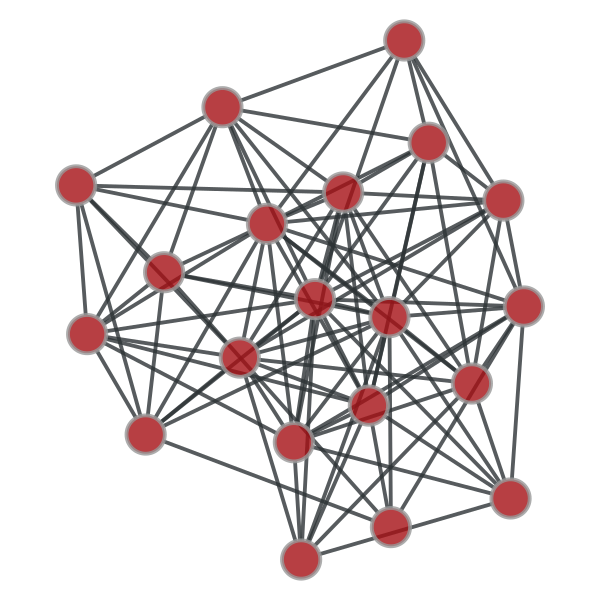

[ 9 12  9 14]


In [83]:
n, k, p = 20, 4, 0.5
# G = gt.Graph(directed=False)
# w = G.new_edge_property("double")
# c = G.new_vertex_property("string")
# for i in range(n):
#     v = G.add_vertex()
#     c[v] = "blue" if i == 0 else "red"
# G.vertex_properties["fill_color"] = c
# for i in range(1, n):
#     w[G.add_edge(0, i)] = 1
#     w[G.add_edge(i, max(1, (i + 1) % n))] = 2
# gt.graph_draw(G, vertex_fill_color=c);
G = gt.random_graph(n, lambda: np.random.poisson(n * p), directed=False);
G.ep["w"] = G.new_ep("double")
G.ep["w"].a = np.random.rand(G.num_edges()) * 42
gt.graph_draw(G);
V0 = np.random.choice(np.arange(n),  k)
print(V0)